In [1]:
import numpy as np
from numba import cuda, float64
import math
from scipy.integrate import quad
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Constants
h = 6.62607015e-34
k = 1.380649e-23
c = 3e8

@cuda.jit(device=True)
def compute_planck_spectrum(nu, T):
    num = 2.0 * h * nu**3 / c**2
    den = math.exp(h * nu / (k * T)) - 1.0
    return num / den

@cuda.jit
def compute_ionizing_flux_kernel(T_array, d_nu, dnu, flux_grid):
    t_idx, nu_idx = cuda.grid(2)

    if t_idx < T_array.size and nu_idx < d_nu.size:
        T = T_array[t_idx]
        nu = d_nu[nu_idx]
        val = compute_planck_spectrum(nu, T)*dnu
        flux_grid[t_idx, nu_idx] = val #griglia Txfreq

@cuda.jit
def sum_kernel(d_T, d_nu, d_flux, d_flux_def):
  idx_t = cuda.grid(1)

  if idx_t < d_T.size:
      for i_nu in range(d_nu.size):
            d_flux_def[idx_t] = d_flux_def[idx_t] + d_flux[idx_t][i_nu]

In [3]:
T_vals = np.linspace(1e4, 1e13, int(1e4))  
nu_min = 13.6 * 1.60218e-19 / h
nu_max = 20.0 * 13.6 * 1.60218e-19 / h
N_nu = int(1e4)
freq_vals = np.linspace(nu_min, nu_max, N_nu)
dnu = freq_vals[1]-freq_vals[0]

T_dev = cuda.to_device(T_vals)
freq_dev = cuda.to_device(freq_vals)
flux_def = np.zeros([T_vals.size, freq_vals.size])
flux_grid_dev = cuda.to_device(flux_def)
flux_def = np.zeros(T_vals.size)
d_flux_def =  cuda.to_device(flux_def)

threadsperblock = (16, 16)
blockspergrid = (
    (T_vals.size + threadsperblock[0] - 1) // threadsperblock[0],
    (N_nu + threadsperblock[1] - 1) // threadsperblock[1]
)
compute_ionizing_flux_kernel[blockspergrid, threadsperblock](T_dev, freq_dev, dnu, flux_grid_dev)
cuda.synchronize()

threadsperblock = (16)
blockspergrid = (
    (T_vals.size + threadsperblock - 1) // threadsperblock
)

sum_kernel[blockspergrid, threadsperblock](T_dev, freq_dev, flux_grid_dev, d_flux_def)

flux_def = d_flux_def.copy_to_host()

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [3]:
# Function to calculate the Planck spectrum for a given temperature
def planck_spectrum(nu, T):
    return (2 * h * nu**3) / (c**2) * (1 / (np.exp(h * nu / (k * T)) - 1))

# Function to calculate the ionizing flux for a given temperature
# The temperature here should be D*T/(1+z) where D is the Doppler factor, 1+z is the gravitational redshift and T is the rest frame wavelength 
def ionizing_flux_element(T):
    def integrand(nu):
        return planck_spectrum(nu, T)
    flux, _ = quad(integrand, 13.6 / h * 1.60218e-19, 20 * 13.6 / h * 1.60218e-19)
    return flux

In [43]:
T_vals = np.linspace(1e8, 1e11, int(1e6))
quad_int = np.zeros(len(T_vals))
for idx,T in enumerate(T_vals):
    quad_int[idx] = ionizing_flux_element(T)

In [47]:
log_x = np.log10(T_vals)
log_y = np.log10(quad_int)

In [48]:
def fit(x, a,b,c, d, e):#,b):#, b, c, d):
    return a+b*x+c*x*x+d*x*x*x+e*x*x*x*x#/(1+np.cosh(x))

In [49]:
param = curve_fit(fit, log_x, log_y, p0=(1., -400, 10,20, 1))

In [50]:
param

(array([ 8.49396521e+00,  1.76942309e+00, -1.12695341e-01,  7.33461259e-03,
        -1.78956502e-04]),
 array([[ 3.75466015e-07, -1.53917548e-07,  2.35870650e-08,
         -1.60166942e-09,  4.06682108e-11],
        [-1.53917548e-07,  6.31252296e-08, -9.67786335e-09,
          6.57449918e-10, -1.67002366e-11],
        [ 2.35870650e-08, -9.67786335e-09,  1.48436553e-09,
         -1.00879517e-10,  2.56351579e-12],
        [-1.60166942e-09,  6.57449918e-10, -1.00879517e-10,
          6.85865109e-12, -1.74357215e-13],
        [ 4.06682108e-11, -1.67002366e-11,  2.56351579e-12,
         -1.74357215e-13,  4.43408930e-15]]))

(8.0, 9.0)

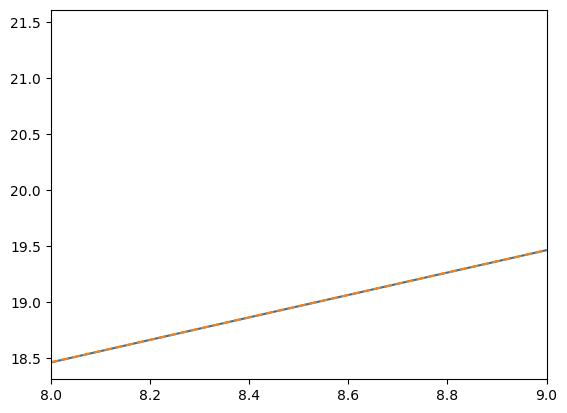

In [52]:
plt.plot(log_x, log_y)
plt.plot(log_x, fit(log_x, *param[0]), linestyle = '--')
plt.xlim(8,9)

In [33]:
def linear_fit(x, a, b, c):
    return a*x**b +c

In [27]:
coeffs

array([ 1.0013706 , 24.06017954])

In [35]:
param = curve_fit(linear_fit, T_vals, quad_int, p0 = (0., 1e10, 0.))

/scratch_local/ipykernel_597167/1384102231.py:2: RuntimeWarning: overflow encountered in power
  return a*x**b +c
/scratch_local/ipykernel_597167/1384102231.py:2: RuntimeWarning: invalid value encountered in multiply
  return a*x**b +c
/scratch_local/ipykernel_597167/3141862089.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  param = curve_fit(linear_fit, T_vals, quad_int, p0 = (0., 1e10, 0.))


In [36]:
param

(array([0.e+00, 1.e+10, 0.e+00]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

/scratch_local/ipykernel_597167/1384102231.py:2: RuntimeWarning: overflow encountered in power
  return a*x**b +c
/scratch_local/ipykernel_597167/1384102231.py:2: RuntimeWarning: invalid value encountered in multiply
  return a*x**b +c


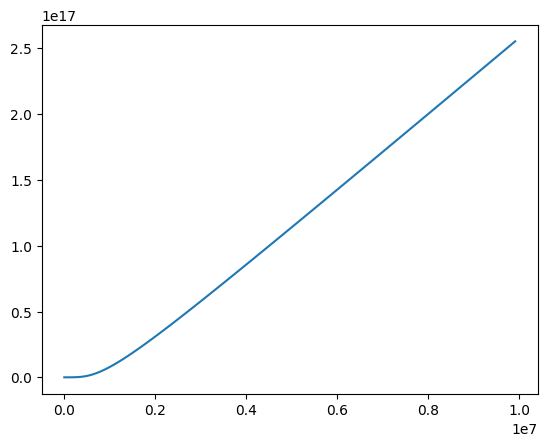

In [37]:
plt.plot(T_vals[:100], quad_int[:100])
plt.plot(T_vals[:100], linear_fit(T_vals[:100], param[0][0], param[0][1], param[0][2]), linestyle = '--')

In [ ]:
idx = 400
print(quad_int[idx], linear_fit(T_vals, param[0][0], param[0][1])[idx], quad_int[idx]/linear_fit(T_vals, param[0][0], param[0][1])[idx])

1.1298798562696101e+18 1.1639357202965824e+18 0.97074076907074


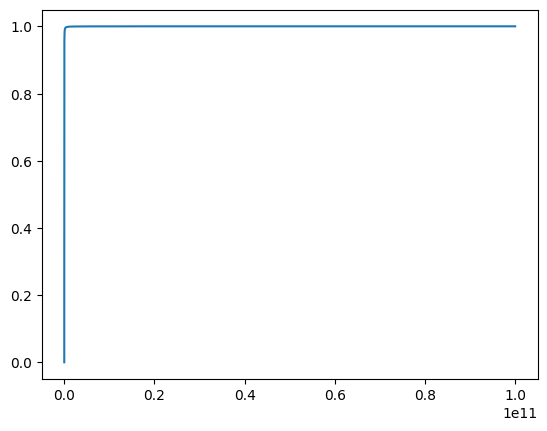

In [ ]:
plt.plot(T_vals, quad_int/linear_fit(T_vals, param[0][0], param[0][1]))

In [ ]:
np.savetxt('integral_grid_resolved.txt', np.column_stack([T_vals, flux_def, quad_int]))